In [1]:
# visualize_clusters.ipynb
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

INPUT_DIR = "./outputs/20231209/clusters/"
OUTPUT_DIR = "./outputs/20231209/"
OUTPUT_REPORT_FILE = f"{OUTPUT_DIR}/cluster_report.txt"

# Read questions into a dictionary
questions_file = "prompts/questions_8.txt"
questions_df = pd.read_csv(questions_file, sep="\t")
questions_dict = {
    f"Q{(row.question_number-1):02d}": row.question
    for index, row in questions_df.iterrows()
}


def clean_column_names(df):
    # Remove all occurrences of commas and spaces from the column names
    df.columns = df.columns.str.replace(r"[,\s]+", "", regex=True)
    return df


def create_primary_cluster_subject_map(clusters_df):
    cluster_to_subjects = {}
    for index, row in clusters_df.iterrows():
        cluster_ids = str(row["cluster_ids"]).strip('"').strip("'").split(",")
        for cluster_id in cluster_ids:
            cluster_id = cluster_id.strip()
            if (
                cluster_id and cluster_id != "nan"
            ):  # Check if cluster_id is not an empty string or 'nan'
                if cluster_id not in cluster_to_subjects:
                    cluster_to_subjects[cluster_id] = []
                cluster_to_subjects[cluster_id].append(row["subject_id"])
    return cluster_to_subjects


def create_secondary_cluster_subject_map(clusters_df):
    cluster_to_subjects = {}
    for index, row in clusters_df.iterrows():
        cluster_ids = str(row["secondary_cluster_ids"]).strip('"').strip("'").split(",")
        for cluster_id in cluster_ids:
            cluster_id = cluster_id.strip()
            if (
                cluster_id and cluster_id != "nan"
            ):  # Check if cluster_id is not an empty string or 'nan'
                if cluster_id not in cluster_to_subjects:
                    cluster_to_subjects[cluster_id] = []
                cluster_to_subjects[cluster_id].append(row["subject_id"])
    return cluster_to_subjects


def parse_cluster_data(input_dir):
    cluster_to_subjects_map = {}
    metadata_files = glob.glob(input_dir + "/Q*metadata*.csv")
    metadata_files.sort()
    cluster_files = glob.glob(input_dir + "/Q*cluster*.csv")
    cluster_files.sort()

    # Process each question
    for metadata_file in metadata_files:
        Q = metadata_file.split("/")[-1].split("_")[0]  # Extract question identifier

        # Read metadata and clean column names
        metadata_df = pd.read_csv(metadata_file)
        metadata_df = clean_column_names(metadata_df)

        try:
            cluster_name_map = metadata_df.set_index("cluster_id")[
                "cluster_name"
            ].to_dict()
            cluster_description_map = metadata_df.set_index("cluster_id")[
                "cluster_description"
            ].to_dict()
        except Exception as e:
            print(f"Exception: {e}, Q: {Q}, file: {metadata_file}")
            print(f"metadata_df.columns: {metadata_df.columns}")

        # Find corresponding cluster file
        cluster_file = next(f for f in cluster_files if Q in f)
        clusters_df = pd.read_csv(cluster_file)
        clusters_df = clean_column_names(clusters_df)
        # Handle 2-level case
        if "top_level_cluster_id" in clusters_df.columns:
            clusters_df.rename(
                columns={"top_level_cluster_id": "cluster_ids"}, inplace=True
            )

        # Process clusters
        primary_cluster_to_subject = create_primary_cluster_subject_map(clusters_df)
        secondary_cluster_to_subject = {}
        if "secondary_cluster_ids" in clusters_df.columns:
            secondary_cluster_to_subject = create_secondary_cluster_subject_map(
                clusters_df
            )

        cluster_to_subjects_map[Q] = (
            cluster_name_map,
            cluster_description_map,
            primary_cluster_to_subject,
            secondary_cluster_to_subject,
        )

    return cluster_to_subjects_map


# Replace './outputs/' with the actual directory path where your files are located
cluster_data = parse_cluster_data(INPUT_DIR)


# cluster_data = parse_cluster_data(OUTPUT_EXCEL_FILE)
list(cluster_data.items())[3]
for question, (
    cluster_name_map,
    cluster_description_map,
    primary_map,
    secondary_map,
) in cluster_data.items():
    print(f"Question: {question}: {questions_dict[question]}")
    keys = list(primary_map.keys())
    keys.sort()
    for key in keys:  # primary_cluster_to_subject mapping
        value = primary_map[key]
        print(f"{key}: {', '.join(map(str, value))}")
    print()

Question: Q00: How old are you?
C1: C001, C004, C005, C006, C007, C008, C010, C015, C019, C024, C025, C032, C035, C036, C037, C041, C049, C056, C058, C059, C062, C066, C067, C071, C072, C076, C077, C079, C082, C084, C093, C094, C095, C098, C100, C101, C102
C2: C009, C011, C014, C018, C020, C021, C023, C026, C033, C034, C039, C040, C042, C044, C047, C054, C060, C061, C063, C064, C065, C069, C070, C073, C075, C081, C083, C087, C096, C097
C3: C002, C016, C022, C028, C038, C043, C045, C046, C051, C057, C074, C080, C085, C090, C099
C4: C003, C029, C031, C053, C086
C5: C012, C017, C030, C048, C050, C052

Question: Q01: Where do you live?
C1: C001, C005, C006, C009, C010, C014, C015, C016, C017, C018, C019, C021, C022, C025, C026, C028, C030, C031, C033, C037, C038, C039, C040, C041, C043, C044, C046, C047, C048, C053, C056, C058, C059, C062, C071, C072, C076, C094, C095, C100, C101, C102
C2: C086, C087, C090, C096, C097, C098
C3: C002, C011, C012, C020, C029, C034, C035, C045, C050, C051, C0

## Text report

In [2]:
import sys


def print_summary_to_file(cluster_data, filename):
    original_stdout = sys.stdout  # Save a reference to the original standard output

    with open(filename, "w") as f:
        sys.stdout = f  # Change the standard output to the file we created.
        print_summary(cluster_data)
        sys.stdout = original_stdout  # Reset the standard output to its original value


def check_non_exclusive_membership(cluster_map):
    subjects_counts = {}
    for subjects_list in cluster_map.values():
        for subject in subjects_list:
            subjects_counts[subject] = subjects_counts.get(subject, 0) + 1
    return any(count > 1 for count in subjects_counts.values())


def print_cluster_summary(
    cluster_type,
    cluster_map,
    cluster_name_map,
    cluster_description_map,
    total_subjects_unique,
):
    non_exclusive_membership = check_non_exclusive_membership(cluster_map)
    membership_label = " [Non-exclusive membership]" if non_exclusive_membership else ""
    print(f"  {cluster_type} Clusters:{membership_label}")

    sorted_cluster_ids = sorted(cluster_map.keys())
    for cluster_id in sorted_cluster_ids:
        subjects = cluster_map[cluster_id]
        percentage = (
            (len(subjects) / total_subjects_unique) * 100
            if total_subjects_unique
            else 0
        )
        print(
            f"    {cluster_id}: {cluster_name_map.get(cluster_id, 'Unassigned')} [{cluster_description_map.get(cluster_id, '')}] -- "
            f"{len(subjects)}/{total_subjects_unique} subject(s) ({percentage:.2f}%)"
        )


def print_summary(cluster_data):
    for question, (
        cluster_name_map,
        cluster_description_map,
        primary_map,
        secondary_map,
    ) in cluster_data.items():
        primary_subjects_unique = set(
            subject
            for subjects_list in primary_map.values()
            for subject in subjects_list
        )
        secondary_subjects_unique = set(
            subject
            for subjects_list in secondary_map.values()
            for subject in subjects_list
        )

        print(
            f"\nQuestion {question} - {questions_dict.get(question, 'Unknown Question')}"
        )

        if primary_map:
            print_cluster_summary(
                "Primary",
                primary_map,
                cluster_name_map,
                cluster_description_map,
                len(primary_subjects_unique),
            )

        if secondary_map:
            print_cluster_summary(
                "Secondary",
                secondary_map,
                cluster_name_map,
                cluster_description_map,
                len(secondary_subjects_unique),
            )


# cluster_data = parse_cluster_data(OUTPUT_EXCEL_FILE)
cluster_data = parse_cluster_data(INPUT_DIR)

# Print summary to console
print_summary(cluster_data)

# Now print the summary to a file
print_summary_to_file(cluster_data, OUTPUT_REPORT_FILE)


Question Q00 - How old are you?
  Primary Clusters:
    C1: Young Adults (22-33) [Subjects who are between 22 and 33 years old] -- 37/93 subject(s) (39.78%)
    C2: Middle-aged Adults (34-45) [Subjects who are between 34 and 45 years old] -- 30/93 subject(s) (32.26%)
    C3: Older Adults (46-60) [Subjects who are between 46 and 60 years old] -- 15/93 subject(s) (16.13%)
    C4: Seniors (61 and above) [Subjects who are 61 years old or above] -- 5/93 subject(s) (5.38%)
    C5: Unclear/irrelevant/no response [Subjects who have not provided their age or their response was unclear or irrelevant] -- 6/93 subject(s) (6.45%)

Question Q01 - Where do you live?
  Primary Clusters:
    C1: Houston, Texas [Subjects reporting their location in Houston, Texas, regardless of specific neighborhood.] -- 42/93 subject(s) (45.16%)
    C2: San Antonio, Texas [Subjects reporting their location in San Antonio, Texas.] -- 6/93 subject(s) (6.45%)
    C3: Texas (Other) [Subjects reporting locations in Texas o

## Plots 

In [3]:
# # Pie Charts
# def generate_pie_chart(
#     Q, cluster_names, cluster_to_subjects, questions, directory="pie_charts"
# ):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Calculate unique subjects for annotation
#     all_subjects = [
#         subject for subjects in cluster_to_subjects.values() for subject in subjects
#     ]
#     unique_subjects = set(all_subjects)
#     total_unique_subjects = len(unique_subjects)

#     # Wrap text for long cluster names
#     labels = [
#         "\n".join(
#             textwrap.wrap(cluster_names.get(cluster_id, "Unknown Cluster"), width=15)
#         )
#         for cluster_id in cluster_to_subjects.keys()
#     ]

#     # Calculate sizes for each cluster
#     sizes = [len(subjects) for subjects in cluster_to_subjects.values()]

#     # Detect non-exclusive membership
#     non_exclusive_membership = check_non_exclusive_membership(cluster_to_subjects)

#     colors = plt.cm.tab20c.colors
#     fig, ax = plt.subplots(figsize=(6, 6))

#     def autopct_format(values):
#         def my_format(pct):
#             # Calculate the absolute number of subjects corresponding to the pct
#             total = sum(values)
#             val = int(round(pct * total / 100.0))
#             return "{:.1f}%\n({}/{})".format(pct, val, total_unique_subjects)

#         return my_format

#     wedges, texts, autotexts = ax.pie(
#         sizes,
#         labels=labels,
#         autopct=autopct_format(sizes),
#         startangle=90,
#         colors=colors[: len(sizes)],
#     )

#     # Set font size for the labels and the percentage texts
#     for text in texts:
#         text.set_fontsize(8)
#     for autotext in autotexts:
#         autotext.set_fontsize(8)
#         autotext.set_weight("bold")

#     # Set the title with non-exclusive membership notice if necessary
#     question_title = questions.get(Q, "Unknown Question")
#     wrapped_title = "\n".join(textwrap.wrap(f"{Q}: {question_title}", width=50))
#     non_exclusive_notice = (
#         " [Non-exclusive membership]" if non_exclusive_membership else ""
#     )
#     ax.set_title(f"{wrapped_title}{non_exclusive_notice}", pad=20)  # Add padding

#     # Ensure that the pie is drawn as a circle and the layout is tight
#     ax.axis("equal")
#     plt.tight_layout()

#     chart_filename = os.path.join(directory, f"{Q}_clusters_pie_chart.pdf")
#     plt.savefig(chart_filename, bbox_inches="tight")
#     plt.close()
#     print(
#         f"Pie chart for {Q} generated with the title: {question_title}{non_exclusive_notice}"
#     )


# # Generate pie charts for each Q in cluster_data
# for Q, (
#     cluster_names,
#     cluster_description_map,
#     primary_cluster_to_subjects_map,
#     _,
# ) in cluster_data.items():
#     generate_pie_chart(
#         Q, cluster_names, primary_cluster_to_subjects_map, questions_dict
#     )

In [4]:
# Bar plots
import os
import textwrap
import matplotlib.pyplot as plt
import numpy as np


def generate_bar_chart(
    Q, cluster_names, cluster_to_subjects, questions, directory="bar_charts"
):
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Calculate unique subjects for annotation
    all_subjects = [
        subject for subjects in cluster_to_subjects.values() for subject in subjects
    ]
    unique_subjects = set(all_subjects)
    total_unique_subjects = len(unique_subjects)

    # Wrap text for long cluster names
    labels = [
        "\n".join(
            textwrap.wrap(cluster_names.get(cluster_id, "Unknown Cluster"), width=15)
        )
        for cluster_id in cluster_to_subjects.keys()
    ]

    # Calculate sizes for each cluster
    sizes = [len(subjects) for subjects in cluster_to_subjects.values()]

    # Detect non-exclusive membership
    non_exclusive_membership = check_non_exclusive_membership(cluster_to_subjects)

    colors = plt.cm.tab20c.colors
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a bar plot
    y_pos = np.arange(len(labels))
    ax.bar(y_pos, sizes, align="center", alpha=0.7, color=colors[: len(sizes)])
    ax.set_xticks(y_pos)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Number of Subjects")
    ax.set_title(f"{Q}: {questions.get(Q, 'Unknown Question')}")

    # Set the title with non-exclusive membership notice if necessary
    question_title = questions.get(Q, "Unknown Question")
    wrapped_title = "\n".join(textwrap.wrap(f"{Q}: {question_title}", width=50))
    non_exclusive_notice = (
        " [Non-exclusive membership]" if non_exclusive_membership else ""
    )
    ax.set_title(f"{wrapped_title}{non_exclusive_notice}", pad=20)  # Add padding

    # Ensure the layout is tight
    plt.tight_layout()

    # Save the bar chart
    chart_filename = os.path.join(directory, f"{Q}_clusters_bar_chart.pdf")
    plt.savefig(chart_filename, bbox_inches="tight")
    plt.close()
    print(
        f"Bar chart for {Q} generated with the title: {question_title}{non_exclusive_notice}"
    )


# Generate bar charts for each Q in cluster_data
for Q, (
    cluster_names,
    cluster_description_map,
    primary_cluster_to_subjects_map,
    _,
) in cluster_data.items():
    generate_bar_chart(
        Q,
        cluster_names,
        primary_cluster_to_subjects_map,
        questions_dict,
        directory=f"{OUTPUT_DIR}/bar_charts",
    )

Bar chart for Q00 generated with the title: How old are you?
Bar chart for Q01 generated with the title: Where do you live?
Bar chart for Q02 generated with the title: What is your marital status?
Bar chart for Q03 generated with the title: Do you have kids?
Bar chart for Q04 generated with the title: If you do have kids, provide details [Non-exclusive membership]
Bar chart for Q05 generated with the title: Are you a caretaker otherwise? (if not own kids, eg elderly parents, adopted family member, etc)
Bar chart for Q06 generated with the title: What type of healthcare professional or student/trainee are you? [Non-exclusive membership]
Bar chart for Q07 generated with the title: If student or trainee, what year are you in?
Bar chart for Q08 generated with the title: What institution did you complete your (or are currently) training at? [Non-exclusive membership]
Bar chart for Q09 generated with the title: If you are a physician, did you train in the US at any point?
Bar chart for Q10 g

## Secondary-level clusters [Not implemented]

## SCRATCH

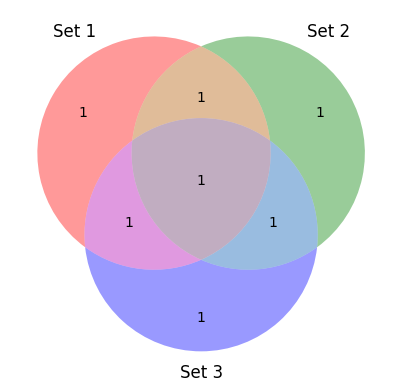

In [5]:
# Create a Venn diagram in Matplotlib
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

set1 = set(["A", "B", "C", "D"])
set2 = set(["B", "C", "E", "F"])
set3 = set(["C", "D", "E", "G"])
venn3([set1, set2, set3], ("Set 1", "Set 2", "Set 3"))
plt.show()